
# **TABLE TRANSFORMER - DETR**
Two functionalities implemented: Table Detection (TD) and Table Structure Recognition (TSR)

## **1.- Install dependencies and download repository**

In [2]:
!rm -r transformers
!git clone -b add_table_transformer https://github.com/nielsrogge/transformers.git
!cd transformers
!pip install -q ./transformers
!pip install -q timm

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 140824, done.
remote: Counting objects: 100% (1127/1127), done.
remote: Compressing objects: 100% (456/456), done.
remote: Total 140824 (delta 737), reused 912 (delta 568), pack-reused 139697
Receiving objects: 100% (140824/140824), 117.67 MiB | 6.98 MiB/s, done.
Resolving deltas: 100% (103828/103828), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 1

## **2.- Download dataset or input images**


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/MyDrive/Colab Notebooks/table_detection/tables.zip" "/content/tables.zip"
!unzip "/content/tables.zip"


Mounted at /content/drive/
Archive:  /content/tables.zip
   creating: tables/
  inflating: tables/Caris_12345678B_00.jpg  
  inflating: tables/Caris_12345678B_01.jpg  
  inflating: tables/Caris_12345678B_03.jpg  
  inflating: tables/Caris_12345678B_04.jpg  
  inflating: tables/Caris_12345678B_05.jpg  
  inflating: tables/Caris_12345678B_06.jpg  
  inflating: tables/Caris_12345678B_07.jpg  
  inflating: tables/Caris_12345678B_08.jpg  
  inflating: tables/Caris_12345678B_15.jpg  
  inflating: tables/Caris_12345678B_16.jpg  
  inflating: tables/Caris_12345678B_17.jpg  
  inflating: tables/Caris_12345678B_18.jpg  
  inflating: tables/Caris_12345678B_19.jpg  
  inflating: tables/Caris_12345678B_20.jpg  
  inflating: tables/Caris_12345678B_21.jpg  
  inflating: tables/Caris_12345678B_22.jpg  
  inflating: tables/Caris_12345678B_23.jpg  
  inflating: tables/Caris_12345678B_24.jpg  
  inflating: tables/Caris_12345678B_25.jpg  
  inflating: tables/Caris_12345678A_01.jpg  
  inflating: tables/Ca

## **3.- Imports**

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import time
from datetime import datetime

from transformers import DetrFeatureExtractor
from transformers import DetrForObjectDetection

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## **4.- Define auxiliar functions**

In [11]:
# colors for visualization
colors = ["red", "blue", "green", "yellow", "orange", "violet"]

# class_to_show:: define results classes that are going to be show:
#   [column, row, column header, row header...]
#   by defaoult 0 = columns
#   use 999 to show all the different objects obtained

def plot_results(pil_img, prob, boxes, model, class_to_show=0):
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show or class_to_show == 999:
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=colors[cl.item()], linewidth=3))
          text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
        else:
          continue
    plt.axis('off')
    plt.show()

In [6]:
def crop_tables(pil_img, prob, boxes, margin=0, class_to_show=0): # class zero is the detected table
    result_images = []
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if cl.item() == class_to_show:
          width, height = pil_img.size
          crop_xmin = max(0, xmin - margin)
          crop_ymin = max(0, ymin - margin)
          crop_xmax = min(width, xmax + margin)
          crop_ymax = min(height, ymax + margin)
          pil_img_crop = pil_img.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))
          result_images.append(pil_img_crop)
        else:
          continue
    return result_images


In [7]:
def add_padding(pil_img, padding, color):
    width, height = pil_img.size
    new_width = width + padding*2
    new_height = height + padding*2
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (padding, padding))
    return result

## **5.- Define and execute main table transformer pipeline**

#### Dataset inference
Execution of the pipeline inference on a dataset of document images

In [13]:
## Input variables
IMG_PATH = r"/content/tables/" # path to the tables dataset
PLOT_RES = 1 # (0:not plot images, 1:plot table detection and table structure results)

## Load models
model_td = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

CONT_IMAS = 0
CONT_TABLES = 0
time_total = 0

files = os.listdir(IMG_PATH)
for file in sorted(files):
  if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".tif"):
    # Input
    file_path = IMG_PATH + file
    image = Image.open(file_path).convert("RGB")
    print("\n\n\n*********************************************************************************************************************")
    print(f"Processing {file_path} ...........")
    CONT_IMAS += 1
    ## Resize
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))

    ### TABLE DETECTION
    start_time_val = datetime.now()
    encoding = feature_extractor(image, return_tensors="pt")
    encoding.keys()
    with torch.no_grad():
      outputs = model_td(**encoding)
    # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
    probas_td = outputs.logits.softmax(-1)[0, :, :-1]
    keep_td = probas_td.max(-1).values > 0.9
    # rescale bounding boxes
    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled_td = postprocessed_outputs[0]['boxes'][keep_td]
    time_td = ((datetime.now() - start_time_val).total_seconds())
    
    image_cropped = crop_tables(image, probas_td[keep_td], bboxes_scaled_td, margin = 20)

    # Table detected
    if image_cropped != []:
      print("... Number of tables detected: ",len(image_cropped))
      ### Show original image with tables detected
      if PLOT_RES == 1:
        plot_results(image, probas_td[keep_td], bboxes_scaled_td, model=model_td)

      for ima_crop in image_cropped:
        CONT_TABLES += 1
        # Padding
        print("... Table structure recognized:")
        ima_crop = add_padding(pil_img = ima_crop, padding = 40, color = (255, 255, 255))

        ### TABLE STRUCTURE RECOGNITION
        start_time_val = datetime.now()
        encoding = feature_extractor(ima_crop, return_tensors="pt")
        encoding.keys()
        # print(encoding['pixel_values'].shape)
        with torch.no_grad():
          outputs = model_tsr(**encoding)
        # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
        probas_tsr = outputs.logits.softmax(-1)[0, :, :-1]
        keep_tsr = probas_tsr.max(-1).values > 0.6
        # rescale bounding boxes
        target_sizes = torch.tensor(ima_crop.size[::-1]).unsqueeze(0)
        postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
        bboxes_scaled_tsr = postprocessed_outputs[0]['boxes'][keep_tsr]
        time_tsr = ((datetime.now() - start_time_val).total_seconds())

        ### Show struture of each table
        if PLOT_RES == 1:
          plot_results(ima_crop, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=999)

        time_total = time_total + time_td + time_tsr

    else:
      print("... Not table detected in ", file_path)
      time_tsr=0

    print(f" TOTAL TIME: {str(time_td + time_tsr)}")

print("\n\n***********************************************************")
print(f"**** Total number of images processed: {CONT_IMAS} ")
print(f"**** Total number of tables detected: {CONT_TABLES} ")
print(f"**** SCORE: {CONT_TABLES/CONT_IMAS}  (supossing one table per image)")
print(f"**** MEAN TIME: {time_total/CONT_TABLES} (with td and tsr)")
print("***********************************************************")

Output hidden; open in https://colab.research.google.com to view.

#### Single inference
Execution of a single inference of an input document image

**TABLE DETECTION RESULT**


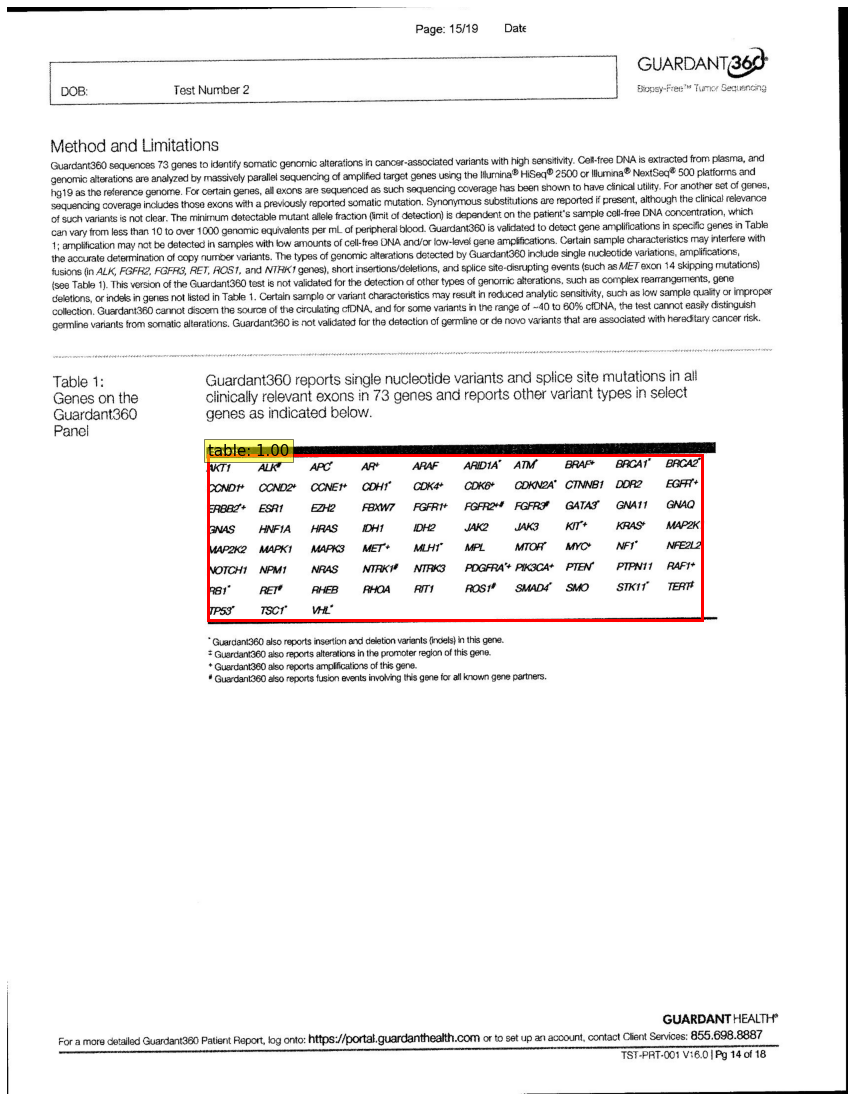


**TABLE STRUCTURE RECOGNITON RESULT**


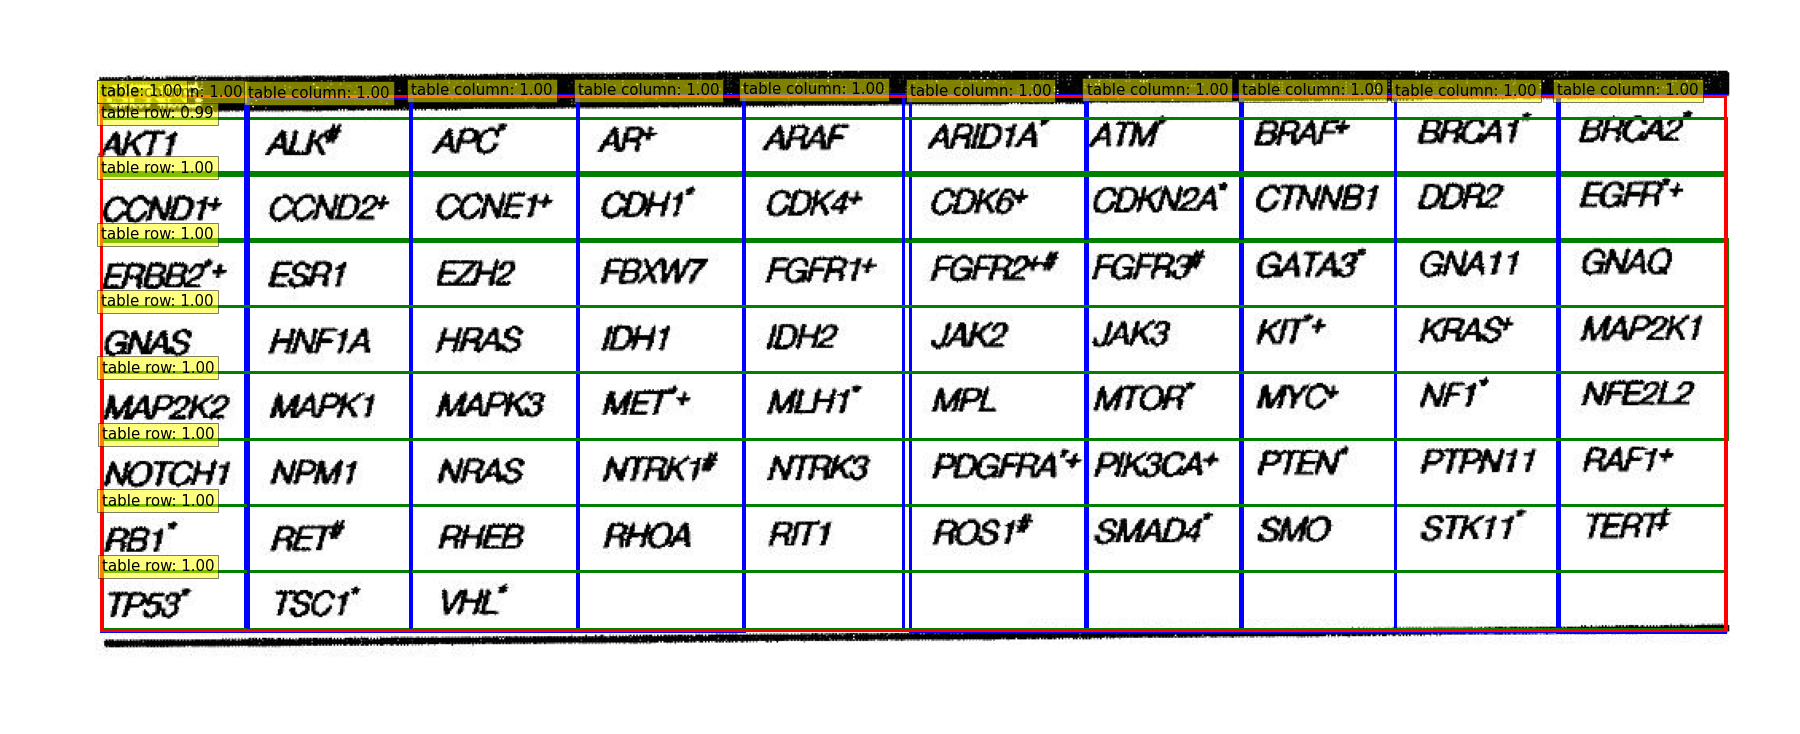

In [15]:
## Input variables
IMG_PATH = r"/content/tables/Guardant_34567891B_13.jpg" # path to the input image
PLOT_RES = 1 # (0:not plot images, 1:plot table detection and table structure results)

# Load models
model_td = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection")
model_tsr = DetrForObjectDetection.from_pretrained("nielsr/detr-table-structure-recognition")
feature_extractor = DetrFeatureExtractor()

# Input image
image = Image.open(IMG_PATH).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

### TABLE DETECTION
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()
with torch.no_grad():
  outputs = model_td(**encoding)
# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas_td = outputs.logits.softmax(-1)[0, :, :-1]
keep_td = probas_td.max(-1).values > 0.9
# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled_td = postprocessed_outputs[0]['boxes'][keep_td]
    
image_cropped = crop_tables(image, probas_td[keep_td], bboxes_scaled_td, margin = 20)

if image_cropped != []:
  ### Show original image with tables detected
  if PLOT_RES == 1:
    print("**TABLE DETECTION RESULT**")
    plot_results(image, probas_td[keep_td], bboxes_scaled_td, model=model_td)

  for ima_crop in image_cropped:
    # Padding
    ima_crop = add_padding(pil_img = ima_crop, padding = 40, color = (255, 255, 255))

    ### TABLE STRUCTURE RECOGNITION
    start_time_val = datetime.now()
    encoding = feature_extractor(ima_crop, return_tensors="pt")
    encoding.keys()
    # print(encoding['pixel_values'].shape)
    with torch.no_grad():
      outputs = model_tsr(**encoding)
    # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
    probas_tsr = outputs.logits.softmax(-1)[0, :, :-1]
    keep_tsr = probas_tsr.max(-1).values > 0.6
    # rescale bounding boxes
    target_sizes = torch.tensor(ima_crop.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled_tsr = postprocessed_outputs[0]['boxes'][keep_tsr]
    time_tsr = ((datetime.now() - start_time_val).total_seconds())

    ### Show struture of each table
    if PLOT_RES == 1:
      print("\n**TABLE STRUCTURE RECOGNITON RESULT**")
      plot_results(ima_crop, probas_tsr[keep_tsr], bboxes_scaled_tsr, model=model_tsr, class_to_show=999)
